# Plot making

## Load packages

In [7]:
import numpy as np
import pandas as pd
import sklearn

np.random.seed(123)

## Computation
### classification data

In [8]:
df_cl = pd.DataFrame(np.random.rand(300,4), columns = ['x', 'y', 'e_x', 'e_y'])
df_cl.e_x = (df_cl.e_x-.5) / 5
df_cl.e_y = (df_cl.e_y-.5) / 5
df_cl['mark'] = df_cl.y > (df_cl.x+df_cl.e_x+.1)**6 + .2 +df_cl.e_y

p = 20
df_cl.x = (df_cl.x*p).round()/p
df_cl.y = (df_cl.y*p).round()/p
df_cl.drop_duplicates(['x', 'y'], inplace=True)

### regression data

In [9]:
n = 200
df_reg = pd.DataFrame({'x':np.random.rand(n), 
                       'e':np.random.normal(size=n,scale=.01)})


df_reg['y'] = df_reg.pipe(lambda d: 3*(d.x**2-d.x) + 0.875+ # fct
                          d.e +  # error
                          np.sin(d.x * np.pi*2*5) / 10) # harmonic vibrations
                         
df_reg.x = (df_reg.x*p).round()/p
df_reg.drop_duplicates('x', inplace=True)

### prediction computation

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

lin_reg = LinearRegression(fit_intercept=False)
log_reg = LogisticRegression(C=10**10, fit_intercept=False, solver='lbfgs', max_iter=10000)

x = np.arange(0,1,.001)
X_1d = x.reshape((1000,1))
grid = np.mgrid[0:1:.01, 0:1:.01]
xx, yy = grid
X_2d = grid.reshape(2,10000).T

# linear model
poly1 = PolynomialFeatures(degree=1,include_bias=True)
X1_1d = poly1.fit_transform(X_1d)
X1_2d = poly1.fit_transform(X_2d)
X1_reg = poly1.fit_transform(df_reg[['x']].values)
X1_class = poly1.fit_transform(df_cl[['x','y']].values)
y_pred_reg_1 = lin_reg.fit(X1_reg, df_reg.y).predict(X1_1d)
y_pred_class_1 = log_reg.fit(X1_class, df_cl.mark).predict_proba(X1_2d)[:,1]
probs_class_1 = y_pred_class_1.reshape(xx.shape)

# non-linear, balanced model
X_bal_1d = np.hstack([np.ones(X_1d.shape), X_1d, X_1d**2])
X_bal_2d = np.hstack([np.ones(X_2d[:,:1].shape), X_2d[:,:1]**6, X_2d[:,1:]])
X_bal_reg = np.hstack([np.ones((len(df_reg), 1)), df_reg[['x']].values, df_reg[['x']].values**2])
X_bal_class = np.hstack([np.ones((len(df_cl),1)), df_cl[['x']].values**6, df_cl[['y']].values])
y_pred_reg_bal = lin_reg.fit(X_bal_reg, df_reg.y).predict(X_bal_1d)
y_pred_class_bal = log_reg.fit(X_bal_class, df_cl.mark).predict_proba(X_bal_2d)[:,1]
probs_class_bal = y_pred_class_bal.reshape(xx.shape)

# non-linear, hypersensitive model
poly_high1 = PolynomialFeatures(degree=15,include_bias=True)
poly_high2 = PolynomialFeatures(degree=7,include_bias=True)
X_high_1d = poly_high1.fit_transform(X_1d)
X_high_2d = poly_high2.fit_transform(X_2d)
X_high_reg = poly_high1.fit_transform(df_reg[['x']].values)
X_high_class = poly_high2.fit_transform(df_cl[['x','y']].values)
y_pred_reg_high = lin_reg.fit(X_high_reg, df_reg.y).predict(X_high_1d)
y_pred_class_high = log_reg.fit(X_high_class, df_cl.mark).predict_proba(X_high_2d)[:,1]
probs_class_high = y_pred_class_high.reshape(xx.shape)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### regularization

In [11]:
def my_fct(x): 
    return 2+8*x**4

np.random.seed(1234)

n_p = 50
X_p = np.arange(0, 1, 1/n_p).reshape((n_p,1))
errors =  np.random.normal(size=(n_p))
y_p = my_fct(X_p[:,0]) + errors



In [12]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  KFold, ShuffleSplit

lin_reg = LinearRegression(fit_intercept=False)
lasso = Lasso(alpha=.02)
kf = KFold(n_splits=10)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

errors = []



def apply_compute_rmse(reg, y, X, train_index, test_index, output = 'rmse', sample='test'):
    reg_fit = reg.fit(X[train_idxs], y_p[train_idxs])  
    
    if output == 'rmse':
        if sample=='test':
            y_pred = reg_fit.predict(X[test_idxs])
            return root_mean_squared_error(y_pred, y_p[test_idxs])
        else:
            y_pred = reg_fit.predict(X[train_idxs])
            return root_mean_squared_error(y_pred, y_p[train_idxs])
    elif output == 'coef':
        return reg_fit.coef_
    else:
        raise ValueError
        
    
    
error_train, error_test = [],[]
error_train_lasso, error_test_lasso = [],[]
coef, coef_lasso = [], []


splits = list(kf.split(y_p))

train_idxs, test_idxs = next(ShuffleSplit(n_splits=1, test_size=.5, random_state=45).split(y_p))

for n in range(10):
    X_p_n = PolynomialFeatures(degree=n, include_bias=True).fit_transform(X_p)
    
    error_in, error_out = [], []
    error_out_lasso, error_in_lasso = [], []
    
    model_input = y_p, X_p_n, train_idxs, test_idxs
    
    coef += [apply_compute_rmse(lin_reg, *model_input, output='coef',sample='train')]
    coef_lasso += [apply_compute_rmse(lasso, *model_input, output='coef',sample='train')]
    error_test.append(apply_compute_rmse(lin_reg, *model_input))
    error_train.append(apply_compute_rmse(lasso, *model_input))
    error_test_lasso.append(apply_compute_rmse(lin_reg, *model_input, sample='train'))
    error_train_lasso.append(apply_compute_rmse(lasso, *model_input, sample='train'))
    

In [13]:
coef_tables = {}

for label, coef_tab in ('lin_reg', coef), ('lasso', coef_lasso):

    coef_table  = \
        pd.concat(dict([(i+1,pd.Series(a)) for i,a in enumerate(coef_tab[:6])]),1)\
            .T\
            .applymap(lambda v: '%.1f' % v if not np.isnan(v) else '')
    coef_table.index = pd.MultiIndex.from_product([['Num. coeff.'], coef_table.index])
    coef_table.columns = pd.MultiIndex.from_product([['Polynomial order'], coef_table.columns])

    coef_tables[label] = coef_table

/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_62463/84190171.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat(dict([(i+1,pd.Series(a)) for i,a in enumerate(coef_tab[:6])]),1)\
/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_62463/84190171.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat(dict([(i+1,pd.Series(a)) for i,a in enumerate(coef_tab[:6])]),1)\


## Making figures

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [15]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
colors = [c for i,c in enumerate(sns.color_palette()) if i in [0,1,5]]

font = {'size'   : 18}
mpl.rc('font', **font)
fig_factor = 1.5
figsize1 = np.array((8,5))*fig_factor
figsize2 = np.array((11,5))*fig_factor
figsize3 = np.array((11,5/3*2))*fig_factor        

def plot_points(ax, title, dtype):
    if dtype=='classification':
        df_cl[df_cl.mark].plot.scatter('x', 'y', color=colors[0],ax=ax)
        df_cl[~df_cl.mark].plot.scatter('x', 'y', color=colors[1],ax=ax)
        ax.set_ylim(-0.05,1.05)
        ax.set_ylabel('x2')
        ax.set_xlabel('x1')
    elif dtype=='regression':
        df_reg.plot.scatter('x','y', ax=ax) 
        ax.set_ylabel('y')
        ax.set_xlabel('x')
    else:
        raise ValueError  
    ax.set_title(title)
    
    
    
model_label = 'estimated model'
dgp_label = 'data generating process'
def plot_line(ax, dtype, ltype):
    if dtype=='classification':
        if ltype == 'true':
            return ax.plot(x[x<.865], (x[x<.865]+.1)**6 + .2, color=colors[2], label=dgp_label)[0]
        elif ltype in ['balanced', 'underfit', 'overfit']:
            if ltype == 'balanced':
                probs_in = probs_class_bal
            elif ltype == 'underfit':
                probs_in = probs_class_1
            elif ltype == 'overfit':      
                probs_in = probs_class_high
            CS = ax.contour(xx, yy, probs_in, levels=[.5], cmap="Greys", vmin=0, vmax=.6)                         
            CS.collections[0].set_label(model_label)
            return CS.collections[0]
        else:
            raise ValueError
        
        
    elif dtype=='regression':
        if ltype == 'true':
            return ax.plot(x, 3*(x**2-x) + 0.875, color=colors[2], label=dgp_label)[0]
        elif ltype == 'balanced':
            return ax.plot(x, y_pred_reg_bal, color='black', label=model_label)[0]
        elif ltype == 'underfit':
            return ax.plot(x, y_pred_reg_1, color='black', label=model_label)[0]
        elif ltype == 'overfit':
            return ax.plot(x, y_pred_reg_high, color='black', label=model_label)[0]
        else:
            raise ValueError
        
    else:
        raise ValueError    
        
        

In [16]:
def format_ax(ax):
    ax.set_xlim([-.05,1.05])
    ax.set_ylim([-.05,1.05])
    ax.set_xticks(np.arange(0,1.01,.2))            
    ax.set_yticks(np.arange(0,1.01,.2))  
    if estimate_type == 'regression':
        ax.set_xlabel('x')            
        ax.set_ylabel('y')     
    else:
        ax.set_xlabel('x1')            
        ax.set_ylabel('x2') 

### Classification vs regression

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

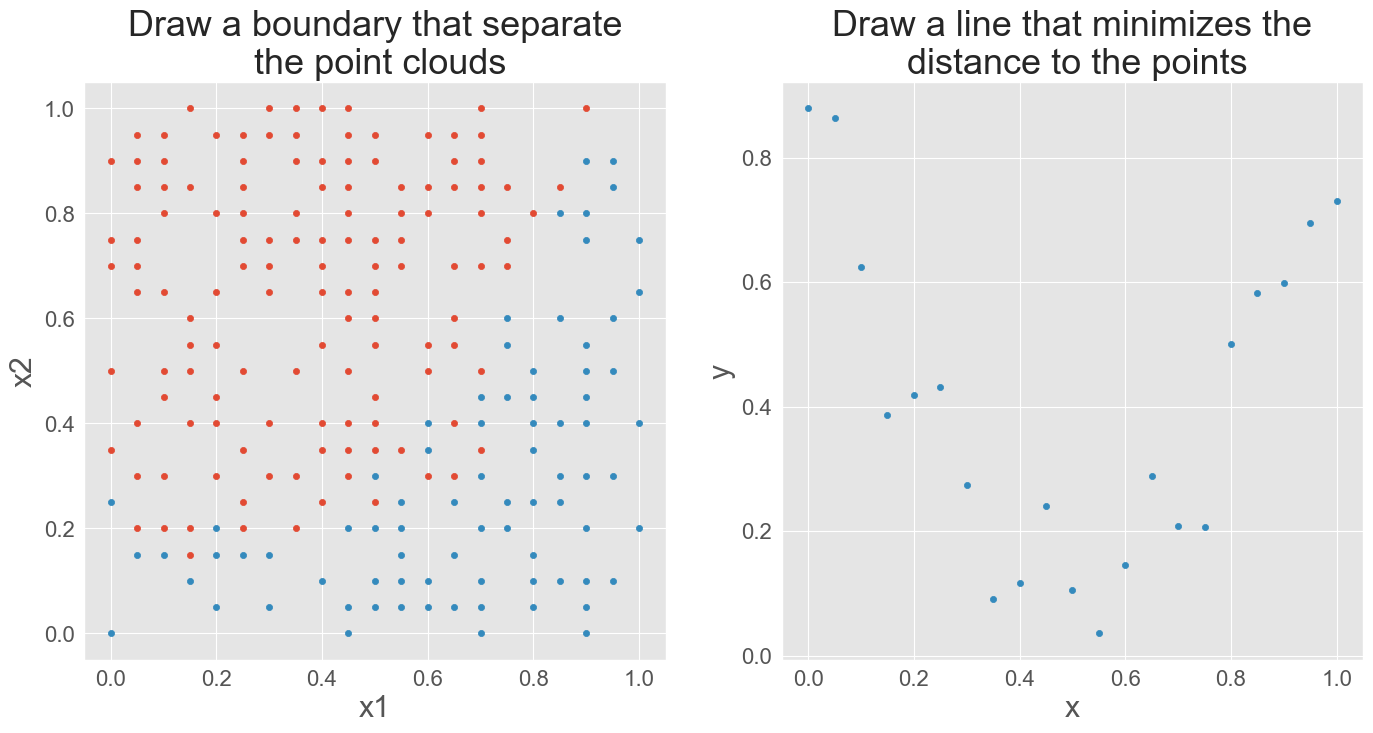

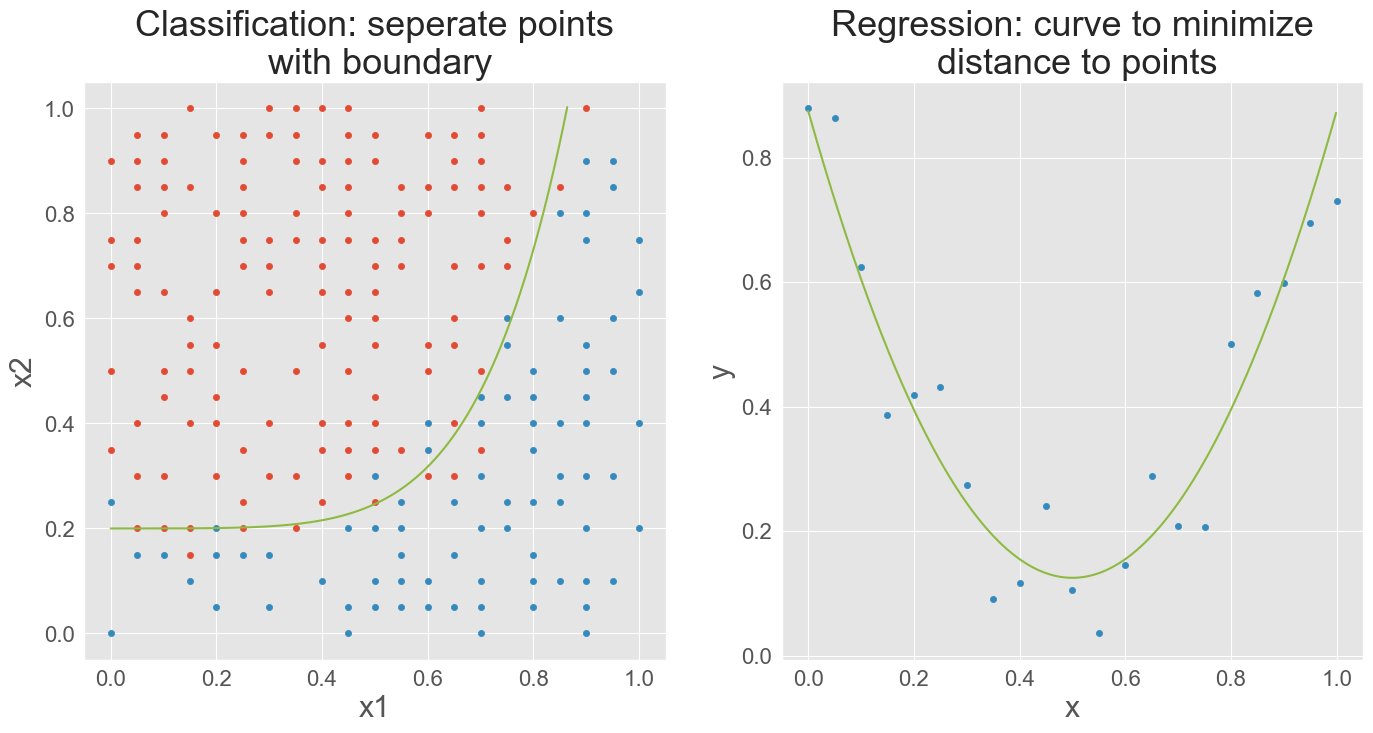

In [17]:
f_identify_question, ax = plt.subplots(1,2, figsize = figsize2)

plot_points(ax[0], 'Draw a boundary that separate\n the point clouds', 'classification')
plot_points(ax[1], 'Draw a line that minimizes the\n distance to the points', 'regression')


f_identify_answer, ax = plt.subplots(1,2, figsize = figsize2)    
plot_points(ax[0], 'Classification: seperate points\n with boundary', 'classification')
plot_points(ax[1], 'Regression: curve to minimize\n distance to points', 'regression')
plot_line(ax[0], 'classification', 'true')
plot_line(ax[1], 'regression', 'true')

### Complexity plots

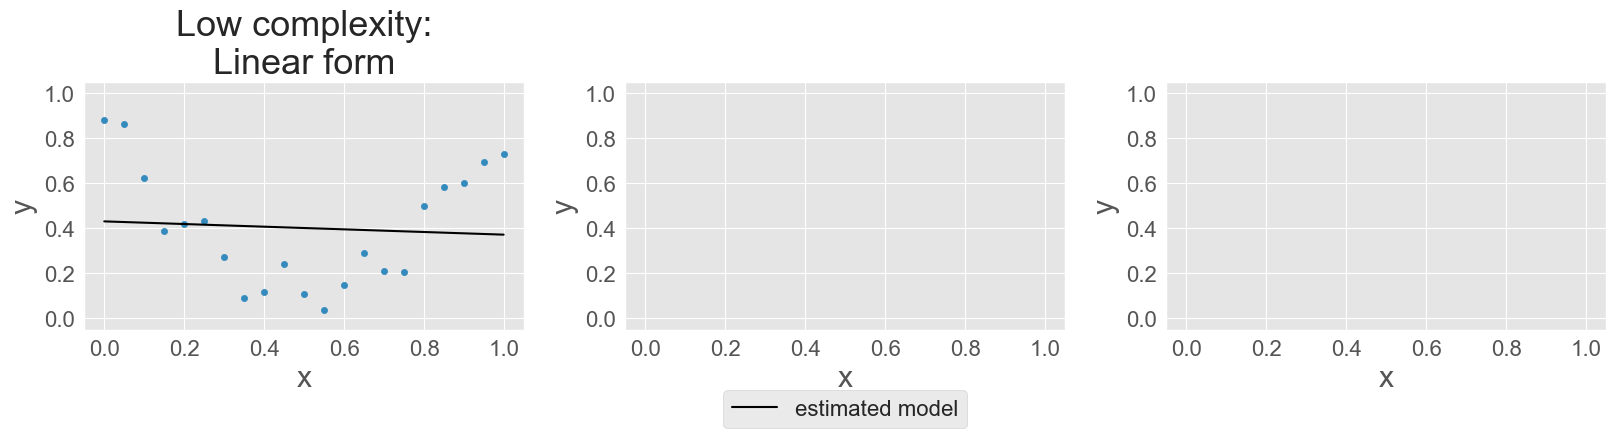

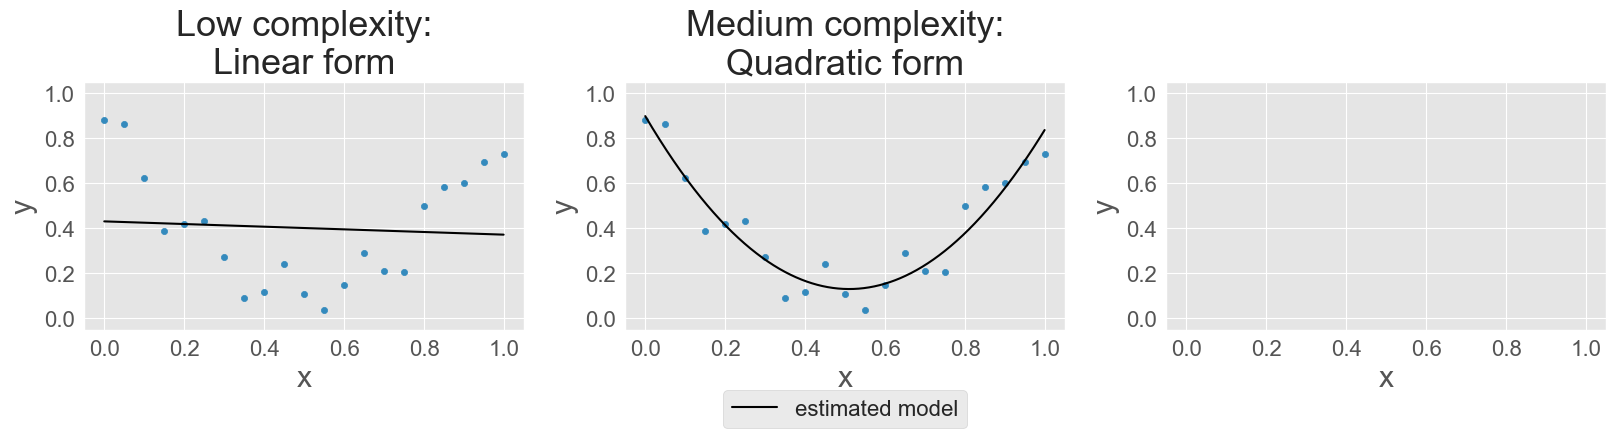

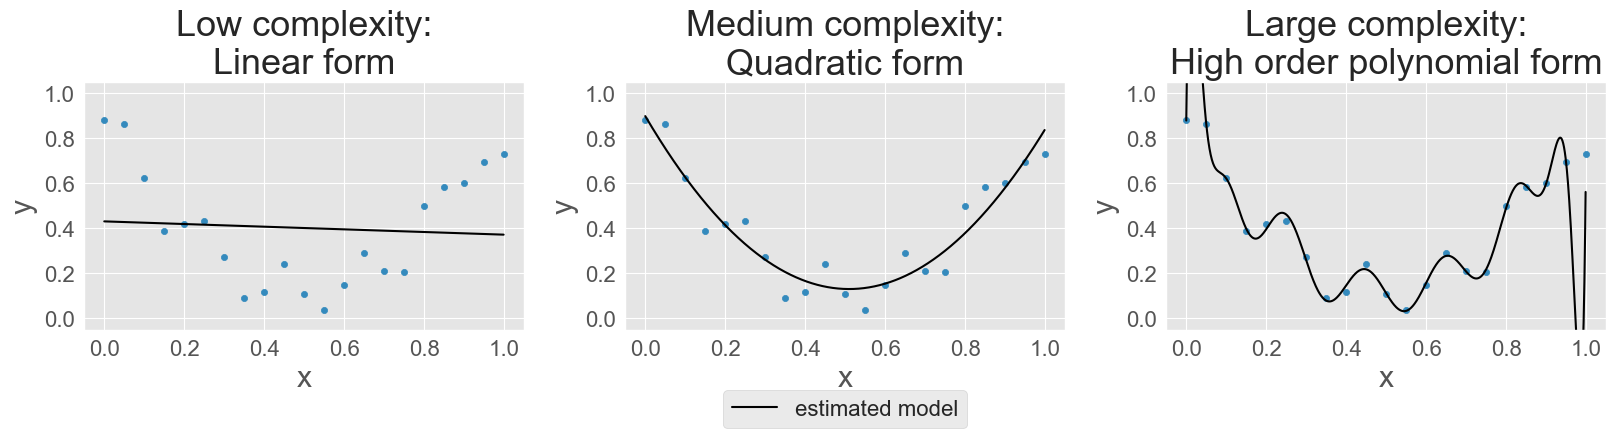

In [18]:
f_complexity = [None]*3

estimate_type = 'regression'

for iteration in range(3):

    f_complexity[iteration], ax = plt.subplots(1,3, figsize = figsize3)

    plot_points(ax[0], 'Low complexity:\nLinear form', estimate_type)
    model = plot_line(ax[0], estimate_type, 'underfit')
        
    if iteration > 0:        
        plot_points(ax[1], 'Medium complexity:\nQuadratic form', estimate_type)
        plot_line(ax[1], estimate_type, 'balanced')


    if iteration > 1:
        plot_points(ax[2], 'Large complexity:\nHigh order polynomial form', estimate_type)
        plot_line(ax[2], estimate_type, 'overfit')
    
    ax[1].legend(handles=[model], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    
    for i in range(3):
        format_ax(ax[i])
    
    plt.tight_layout()

### Bias variance tradeoff 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

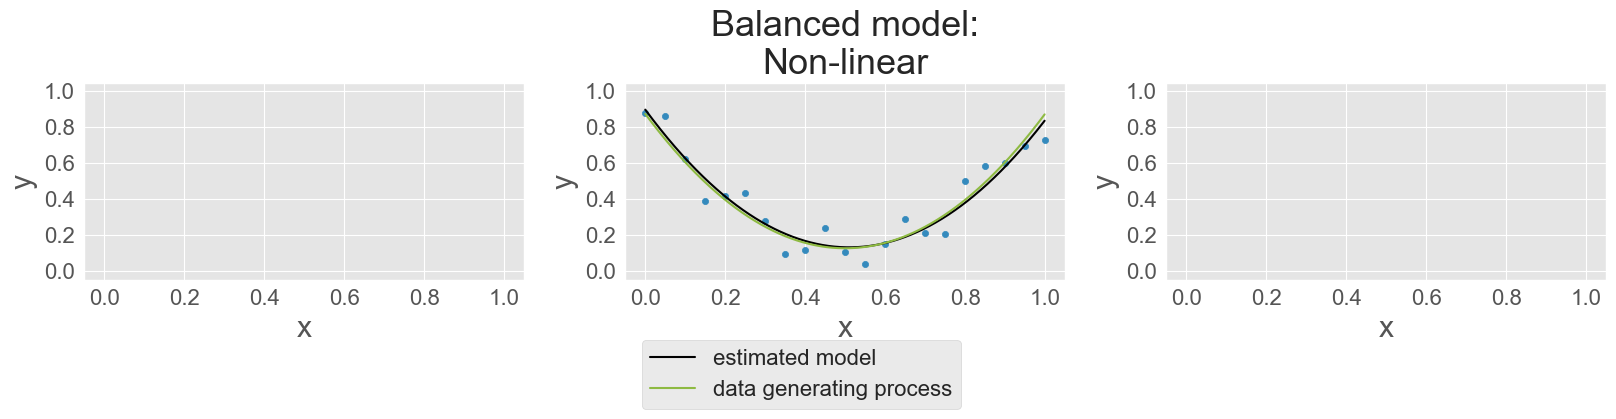

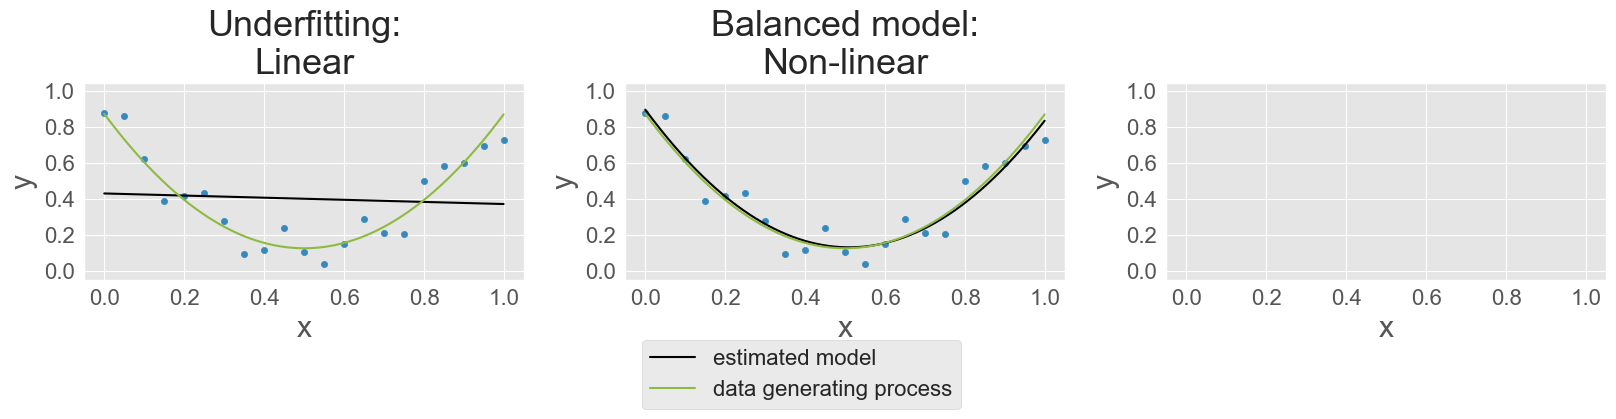

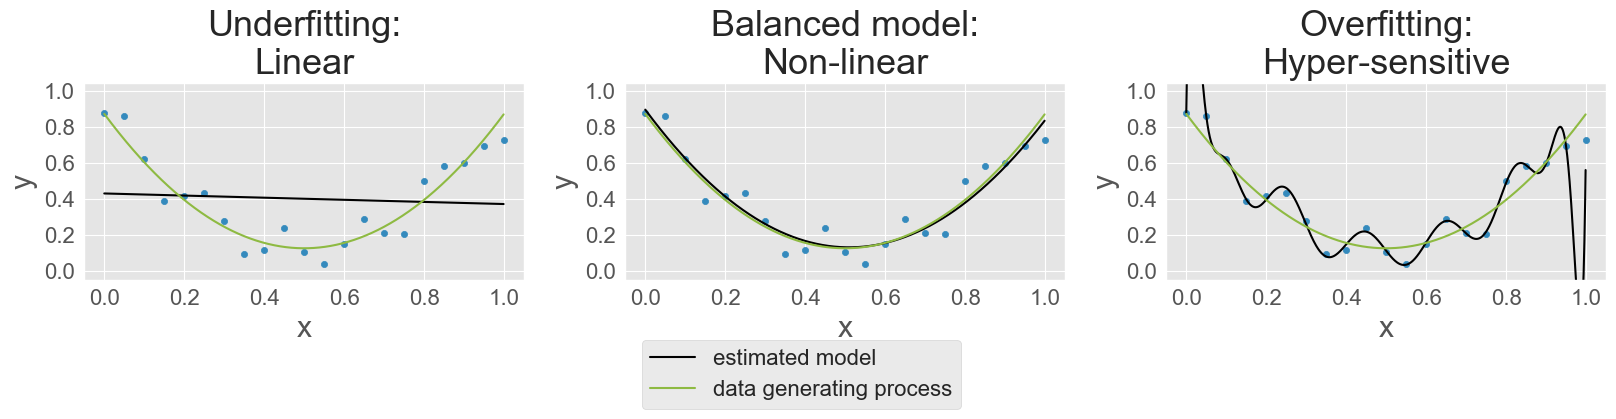

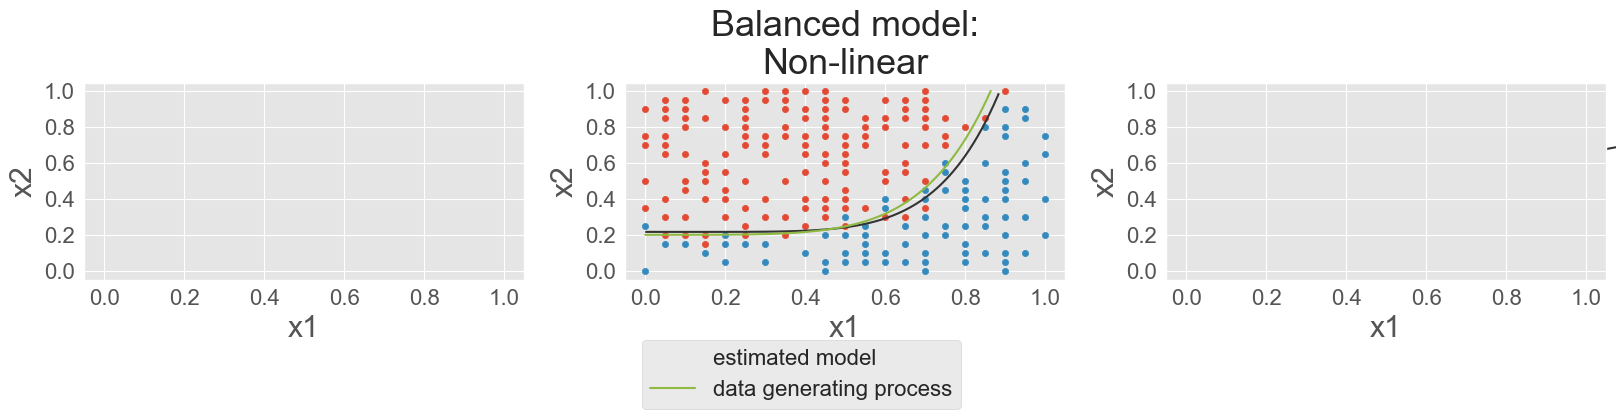

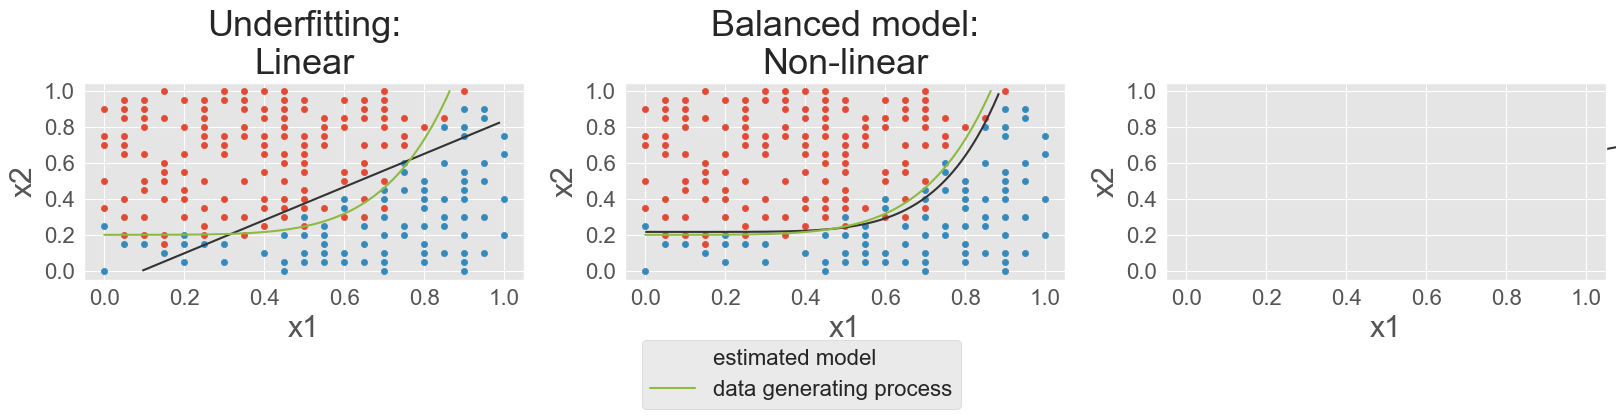

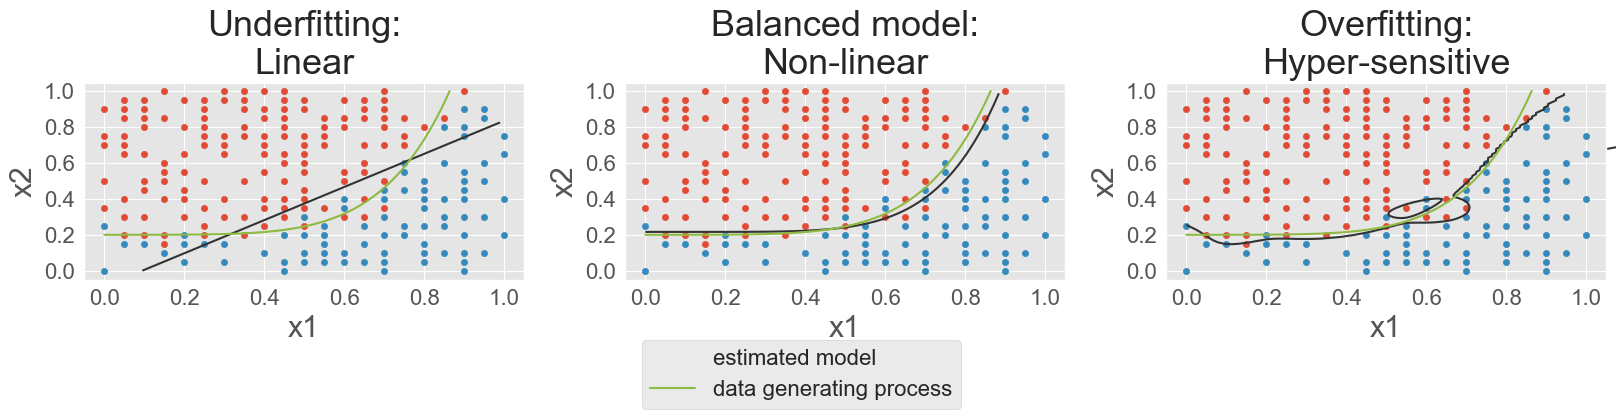

In [19]:
f_bias_var = {}

for estimate_type in 'regression', 'classification':
    f_bias_var[estimate_type] = [None]*3

    for iteration in range(3):

        f_bias_var[estimate_type][iteration], ax = plt.subplots(1,3, figsize = figsize3)

        plot_points(ax[1], 'Balanced model:\nNon-linear', estimate_type)
        model = plot_line(ax[1], estimate_type, 'balanced')
        dgp = plot_line(ax[1], estimate_type, 'true')
        
        ax[1].legend(handles=[model, dgp], loc='upper center', bbox_to_anchor=(.4, -.25), ncol=1)
        
        
        if iteration > 0:        
            plot_points(ax[0], 'Underfitting:\nLinear', estimate_type)
            plot_line(ax[0], estimate_type, 'underfit')
            plot_line(ax[0], estimate_type, 'true')
            

        if iteration > 1:
            plot_points(ax[2], 'Overfitting:\nHyper-sensitive', estimate_type)
            plot_line(ax[2], estimate_type, 'overfit')
            plot_line(ax[2], estimate_type, 'true')
        
        for j in range(3):            
            format_ax(ax[j])
        
        
        plt.tight_layout()

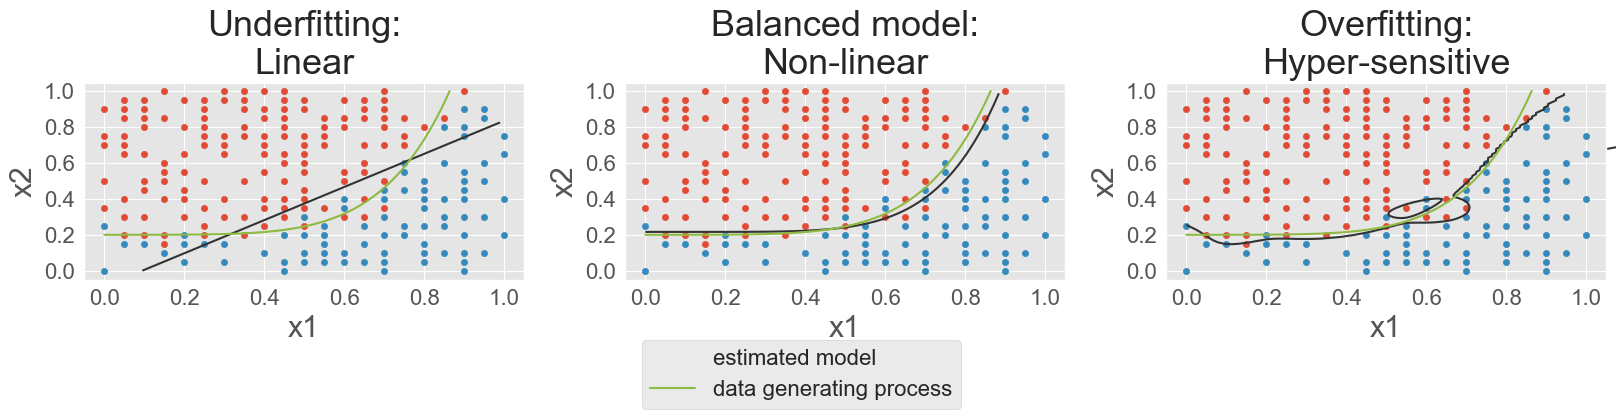

In [20]:
f_bias_var['classification'][2]